# Temporal Interpolation

In this tutorial, we'll take a look at the `TimeSeries.interpolate_time` and `TimeSeries.insert_image` methods in `wxee`to see how they can be used to fill missing data.

## Setup

In [ ]:
!pip install wxee

In [1]:
import ee
import wxee

ee.Authenticate()
ee.Initialize()

## Interpolating Data

Interpolation allows you to synthesize data between existing data points. In this case, we'll interpolate gridded precipitation data between daily outputs from the [gridMET model](https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_GRIDMET).

To begin with, we'll create a `TimeSeries` object of daily precipitation data.

In [2]:
ts = wxee.TimeSeries("IDAHO_EPSCOR/GRIDMET").select("pr")

We could interpolate directly from this time series which contains data between 1979 and present, but it will run faster if we subset our time series around our period of interest.

Let's select 2 days of data in January of 1985.

In [3]:
ts_sub = ts.filterDate("1985-01-26", "1985-01-28")

ts_sub.describe("day")

IDAHO_EPSCOR/GRIDMET
	Images: 2
	Start date: 1985-01-26 06:00:00 UTC
	End date: 1985-01-27 06:00:00 UTC
	Mean interval: 1.00 days


Now we'll use linear interpolation to predict rainfall at 18:00 UTC on June 28. Because our `TimeSeries` data is acquired daily at 06:00 UTC, this will be interpolated halfway between our two existing grids.

In [4]:
target_time = ee.Date("1985-01-26T18")
interp = ts_sub.interpolate_time(target_time, method="linear")

The `TimeSeries.interpolate_time` method returns the interpolated image. If we want to add the interpolated data back into our time series, we can use the `TimeSeries.insert_image` method.

In [5]:
ts_interp = ts_sub.insert_image(interp)
ts_interp.describe("day")

IDAHO_EPSCOR/GRIDMET
	Images: 3
	Start date: 1985-01-26 06:00:00 UTC
	End date: 1985-01-27 06:00:00 UTC
	Mean interval: 0.50 days


Notice that we now have three images instead of two, and the mean daily interval has decreased. Let's download our time series and take a look at the synthesized data.

In [6]:
ds = ts_interp.wx.to_xarray(scale=20_000, crs="EPSG:5070")

Requesting data:   0%|          | 0/3 [00:00<?, ?it/s]

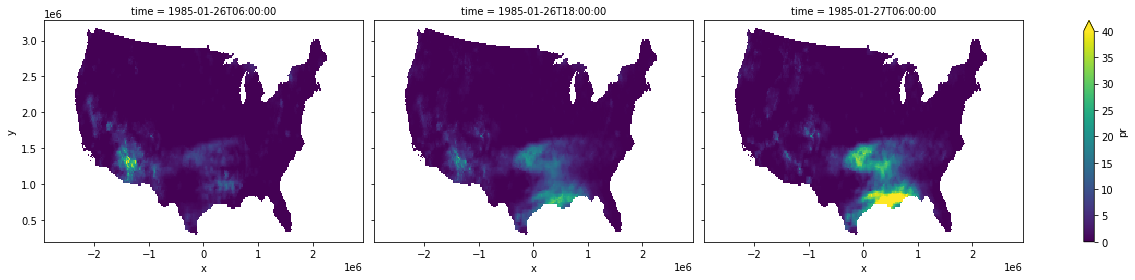

In [7]:
ds.pr.plot(col="time", aspect=1.4, size=4, vmin=0, vmax=40)

It's a bit hard to tell, but our predicted 18:00 UTC precipitation is linearly interpolated between our existing data points. That should be a little clearer if we look at the mean precipitation over the United States.

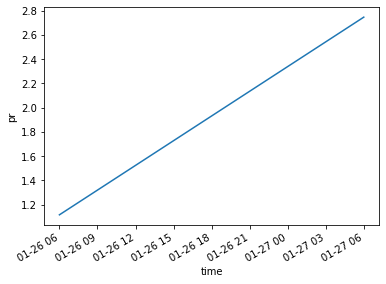

In [8]:
ds.pr.mean(["x", "y"]).plot()

## Comparing Interpolation Methods

To compare the results of different interpolation methods, we'll see how their predictions compare by synthesizing missing data and comparing the predictions to real data.

To start off with, we'll load 4 months of temperature data around (but  not including) July of 2005. We'll also load the missing July data as a separate image.

In [9]:
ts_missing = wxee.TimeSeries([
    "ECMWF/ERA5_LAND/MONTHLY/200505",
    "ECMWF/ERA5_LAND/MONTHLY/200506",
    # Skip July
    "ECMWF/ERA5_LAND/MONTHLY/200508",
    "ECMWF/ERA5_LAND/MONTHLY/200509",
]).select("temperature_2m").map(lambda img: img.rename("actual"))


missing_month = ee.Image("ECMWF/ERA5_LAND/MONTHLY/200507").select("temperature_2m").rename("actual")

Now we'll iterate over our interpolation methods, creating a `TimeSeries` from each by filling in July using `interpolate_time` and adding it back to the time series using `insert_image`. We'll set their band names to help us track which is which and merge each into an empty `TimeSeries` so that we can download them in one go.

In [10]:
fill_date = ee.Date("2005-07")

ts = wxee.TimeSeries([])

for method in ["nearest", "linear", "cubic"]:
    interp_july = ts_missing.interpolate_time(fill_date, method)
    ts_interp = ts_missing.insert_image(interp_july).map(lambda img: img.rename(method))
    
    ts = ts.merge(ts_interp)

Finally, we'll insert the *actual* July data into the `TimeSeries`.

In [11]:
ts = ts.merge(ts_missing.insert_image(missing_month))

Now we can download the `TimeSeries` containing our interpolated and actual data and visualize our predictions. We'll do this within a region we define around Iceland.

In [12]:
region = ee.Geometry.Polygon(
        [[[-74.89613274249616, 84.1363940126967],
          [-74.89613274249616, 58.87152610826001],
          [-7.923476492496146, 58.87152610826001],
          [-7.923476492496146, 84.1363940126967]]])

ds = ts.wx.to_xarray(region=region)

Requesting data:   0%|          | 0/20 [00:00<?, ?it/s]

First off, let's just look at the July temperature grids we created with each method.

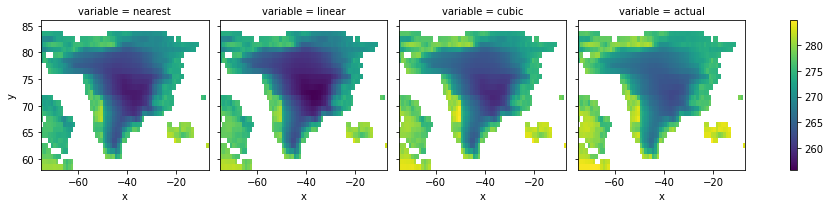

In [13]:
ds.sel(time="2005-07").to_array().plot(col="variable")

It looks like `cubic` was the closest to `actual` July data, but it's hard to tell from a map. Instead, we'll compare mean temperatures over the region between methods.

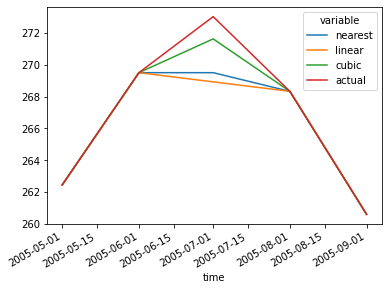

In [14]:
ds.mean(["x", "y"]).to_array().plot(hue="variable")

Now it's clear: `cubic` clearly came the closest to the actual data, but it still underestimated temperatures.